In [63]:
import pylablib.aux_libs.devices.DCAM as cam
from pylablib.aux_libs.devices.DCAM_lib import lib, DCAMLibError

import matplotlib.pyplot as plt
import sys
sys.path.append('C:\\Users\\IFIc\\Projects\\sabatsw\\laserlab\\scripts')
from galvo_python.galvos import *
from galvo_python.gaussian2dFit import *
from time import sleep
import logging
import warnings
from skimage import io

In [37]:
logging.getLogger().setLevel(logging.CRITICAL)

## Initialize camera and galvos 

In [4]:
serialport = open_serial_port()

In [5]:
cam.get_cameras_number(), cam.DCAMCamera(0).get_model_data()

(1,
 ModelData(vendor='Hamamatsu', model='C13440-20C', serial_number='S/N: 303065', camera_version='4.31.B'))

In [8]:
cam0 = cam.DCAMCamera(0)
lib.dcamapi_uninit()     # For some reason this must be run before opening the camera
cam0.open()

min_texp = cam0.properties['EXPOSURE TIME'].min
cam0.set_value('EXPOSURE TIME', min_texp)

cam0.start_acquisition()
cam0.get_status()

'busy'

In [ ]:
cam0.stop_acquisition()

#  Take snap

In [ ]:
center0 = [int(65534./2) + 3150, int(65534./2) +  4650] #calibrated on 26/05/2020, normal incidence on galvo

move_to_positionXY(serialport, [0,0], center=center0)

[15528.541359356408,
 1137.6431577502924,
 1659.1570999140222,
 247.38491363910413,
 0.007281578924037395]

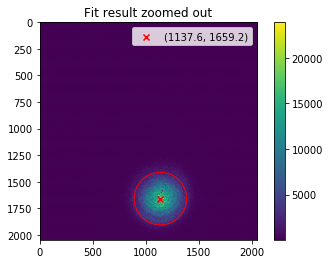

In [15]:
frame = cam0.get_frame(100)

gray = plt.imshow(frame)
plt.colorbar(gray)

guessNfitGaussian2d(frame, flag_p=True)

## Check reference image size right after galvo 

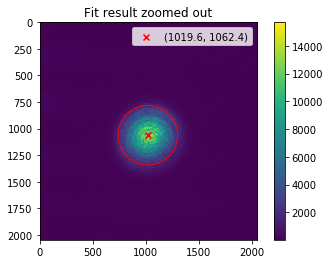

In [16]:
frameRef = plt.imread("./aligning_4f_052020/nolens_noiris_3cm.tiff")
gray = plt.imshow(frameRef)
plt.colorbar(gray)

bestfit1 = guessNfitGaussian2d(frameRef, flag_p=True)

In [17]:
xref, yref = bestfit1[1:3]
rRef = bestfit1[3]
rRef

280.7183325525021

## Realigning without lenses, with 2 pinholes 

The procedure is the following:

- Use the first aligning mirror to direct the spot to the center of both galvo mirrors
- Use the second aligning mirror to focus it through the first pinhole
- To make the spot pass through the second pinhole, play with the second aligning mirror, the rotation of the galvos (not the position, just for large adjustment) and the origin of the galvos rotation (center0) for fine tuning. 

# Find lens 2 focus and center 

## Center

<IPython.core.display.Javascript object>


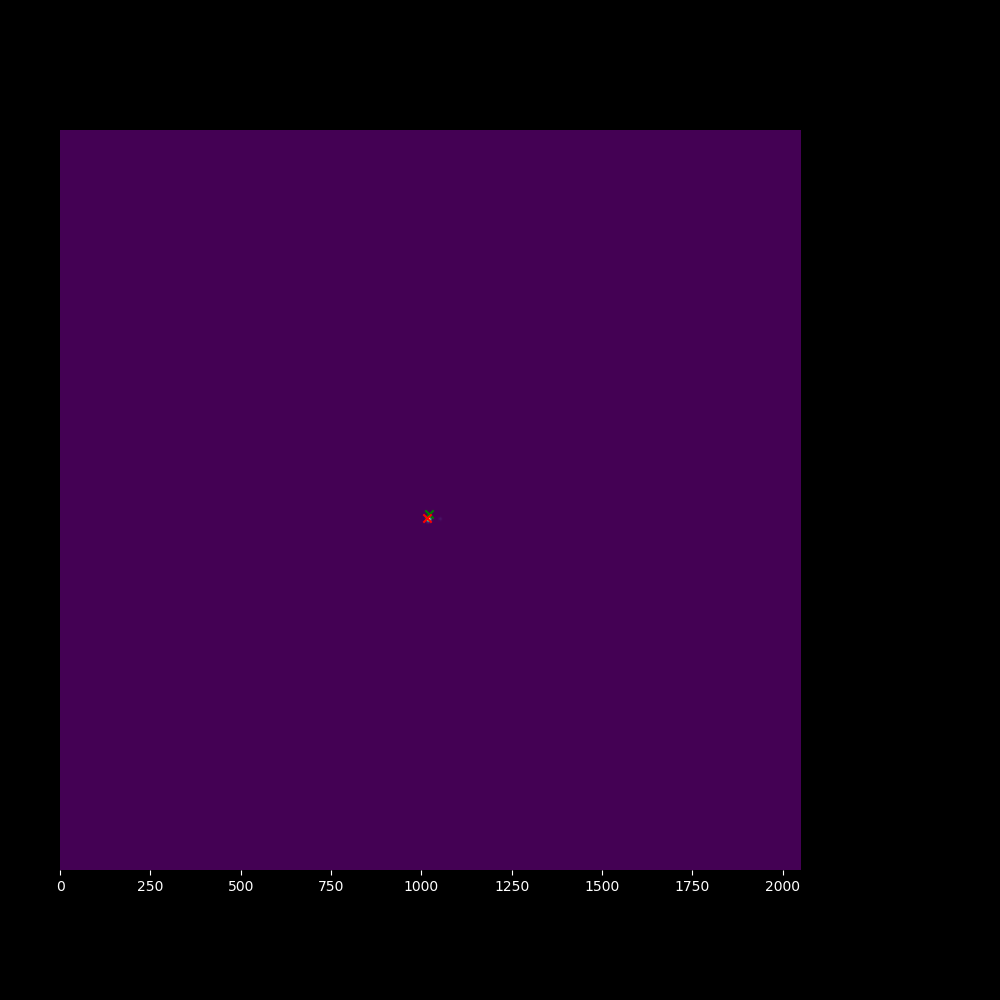

KeyboardInterrupt: 

In [29]:
%matplotlib notebook
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,10))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []
while True:
    fig = plt.gcf()
    ax1 = fig.add_subplot(1, 1, 1)
    
    frame0 = cam0.get_frame(100)

    img = ax1.imshow(frame0)
    fig.colorbar(img)
    mx = guess_centroid(frame0)

    ax1.scatter(x=xref, y=yref, marker='x',
     color='g', label = 'Ref: (%.1f, %.1f)' %(xref, yref))
    
    ax1.scatter(x=mx[1], y=mx[0], marker='x',
     color='r', label = '(%.1f, %.1f)' %(mx[0], mx[1]))
    ax1.legend()

    fig.canvas.draw()
    fig.tight_layout()
    #fig.canvas.update()
    fig.canvas.flush_events()
    plt.clf()

## Focus z

<IPython.core.display.Javascript object>


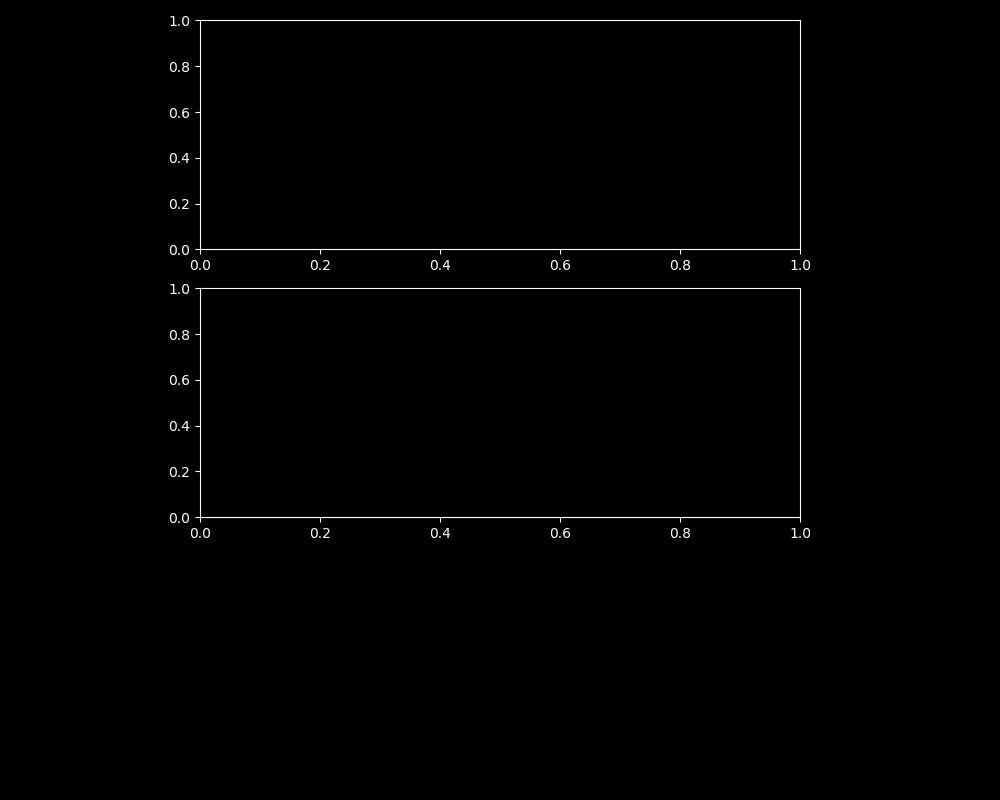

KeyboardInterrupt: 

In [30]:
%matplotlib notebook
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,8))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []

frame0 = cam0.get_frame(100)
mx = guess_centroid(frame0)
bounds = bound_roi(frame0, mx, size = 400)
imroi = select_roi(frame0, bounds)
mxroi = guess_centroid(imroi)
fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=False)
sigma_x = fitc[2]
sigma_y = fitr[2]
p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]

while True:
    
    fig = plt.gcf()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)

    frame0 = cam0.get_frame(100)
    
    mx = guess_centroid(frame0)
    bounds = bound_roi(frame0, mx, size = 400)
    imroi = select_roi(frame0, bounds)
    try:
        fit = fitGauss2d(imroi, p0 = p0)
        pars = make_params(fit);
        if (pars[3] > 0 ) and (pars[3] < 200):
            sx.append(pars[3])
        ax2.plot(sx, label='$w$')
        #ax2.set_ylim(15, 25)
        ax2.legend()
    
    except RuntimeError:
        pass
    
    pars = zoom_out(pars, bounds)
    plot_fit_result(frame0, pars, ax=ax1);
    fig.canvas.draw()
    fig.tight_layout()
    #fig.canvas.update()
    fig.canvas.flush_events()
    fig.subplots_adjust(left=0.2, bottom=None, right=0.8, top=None, wspace=0.1, hspace=None)
    plt.clf()     # Clean figure to update legend, barplot...    

##### With strictly normal incidence on the galvo, the focus distance is the actual one (40 cm) 

The waist in the focus is w = 8.7 px

# Find lens 1 position and center 

<IPython.core.display.Javascript object>


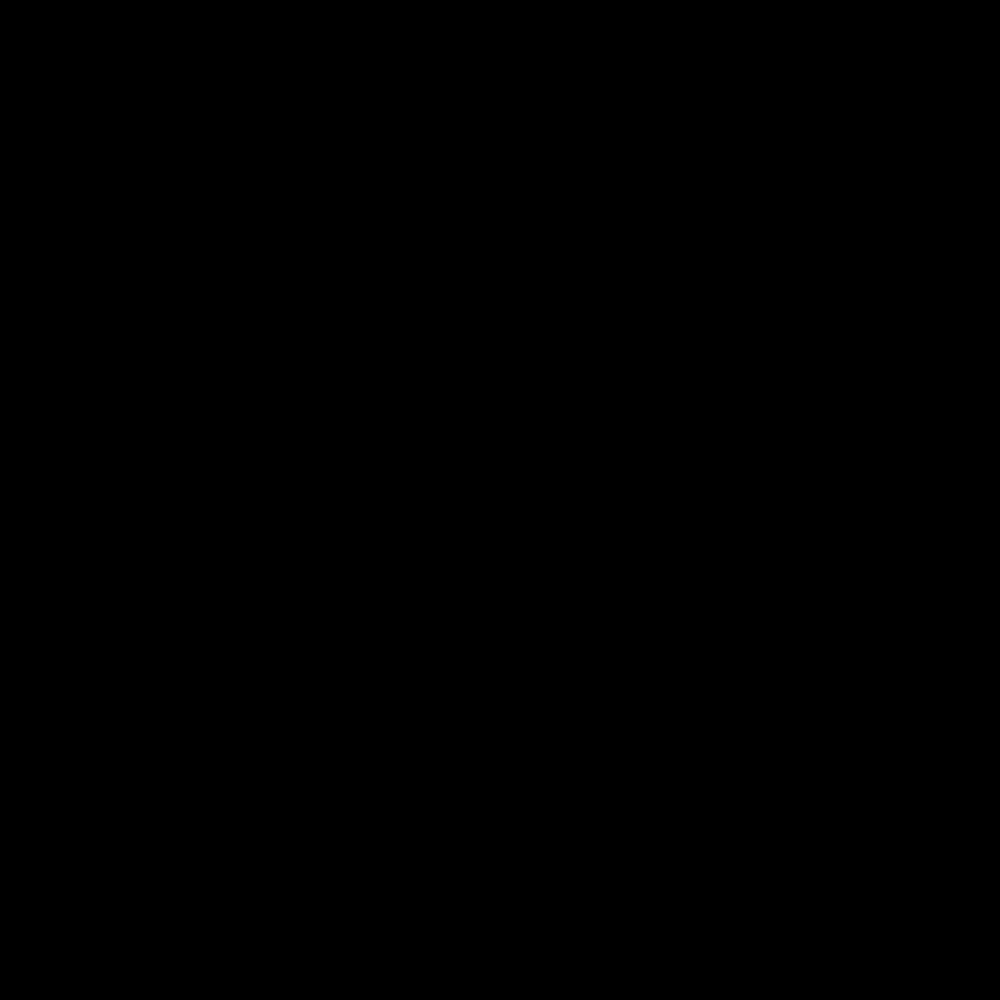

KeyboardInterrupt: 

In [31]:
%matplotlib notebook
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,10))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []
while True:
    fig = plt.gcf()
    ax1 = fig.add_subplot(1, 1, 1)
    
    frame0 = cam0.get_frame(100)

    img = ax1.imshow(frame0)
    fig.colorbar(img)
    mx = guess_centroid(frame0)

    ax1.scatter(x=xref, y=yref, marker='x',
     color='g', label = 'Ref: (%.1f, %.1f)' %(xref, yref))
    
    ax1.scatter(x=mx[1], y=mx[0], marker='x',
     color='r', label = '(%.1f, %.1f)' %(mx[0], mx[1]))
    ax1.legend()

    fig.canvas.draw()
    fig.tight_layout()
    #fig.canvas.update()
    fig.canvas.flush_events()
    plt.clf()

<IPython.core.display.Javascript object>


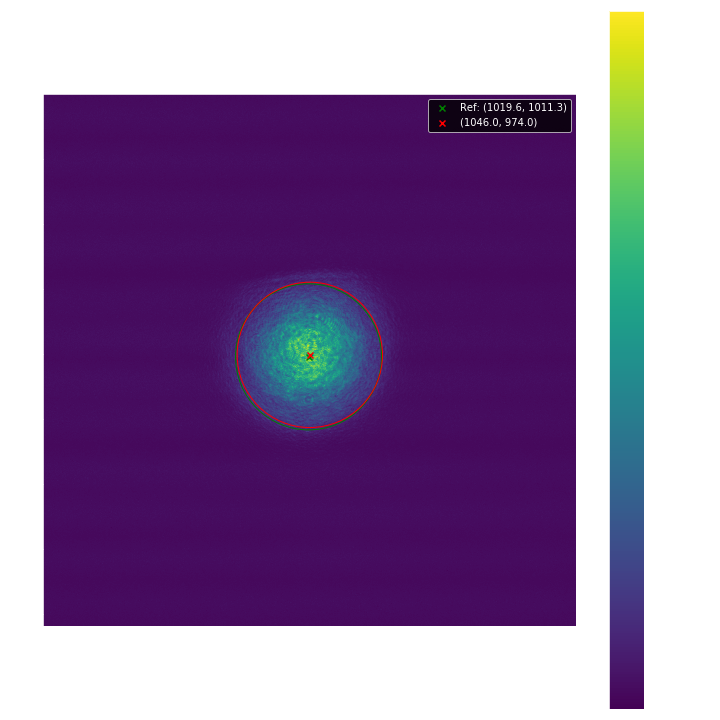

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


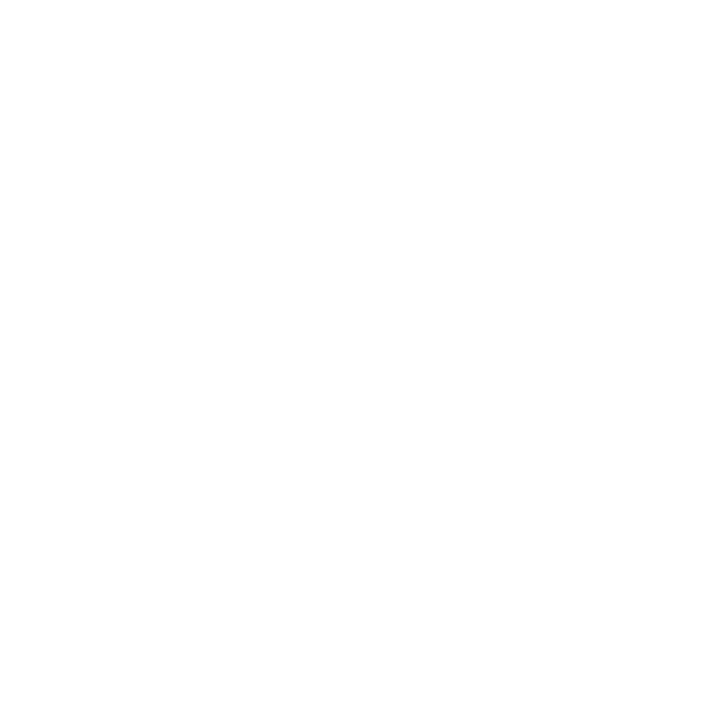

In [135]:
%matplotlib notebook
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,10))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []
while True:
    fig = plt.gcf()
    ax1 = fig.add_subplot(1, 1, 1)
    
    frame0 = cam0.get_frame(100)

    img = ax1.imshow(frame0)
    fig.colorbar(img)
    mx = guess_centroid(frame0)
 
    ax1.scatter(x=xref, y=yref, marker='x',
     color='g', label = 'Ref: (%.1f, %.1f)' %(xref, yref))

    circleRef = plt.Circle((xref, yref), radius=rRef, color='g', lw=1, fill=False,
     label = '$\omega = $ %.1f' %rRef)
    ax1.add_artist(circleRef)
    
    bounds = bound_roi(frame0, mx, size = 400)
    imroi = select_roi(frame0, bounds)
    mxroi = guess_centroid(imroi)

    try:
        fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=False)
        sigma_x = fitc[2]
        sigma_y = fitr[2]
        p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
        fit = fitGauss2d(imroi, p0 = p0)
        pars = make_params(fit);
        p0 = zoom_out(pars, bounds)

    except RuntimeError:
        pass
    
    ax1.scatter(x=p0[1], y=p0[2], marker='x',
     color='r', label = '(%.1f, %.1f)' %(mx[1], mx[0])) 
    
    circle = plt.Circle((p0[1], p0[2]), radius=p0[3], color='r', lw=1, fill=False,
     label = '$\omega, = $ %.1f' %p0[3])
    
#    plot_fit_result(frame0, pars, ax=ax1);
    ax1.add_artist(circle)
    ax1.legend()
    fig.canvas.draw()
    fig.tight_layout()
    #fig.canvas.update()
    fig.canvas.flush_events()
    plt.clf()

<IPython.core.display.Javascript object>


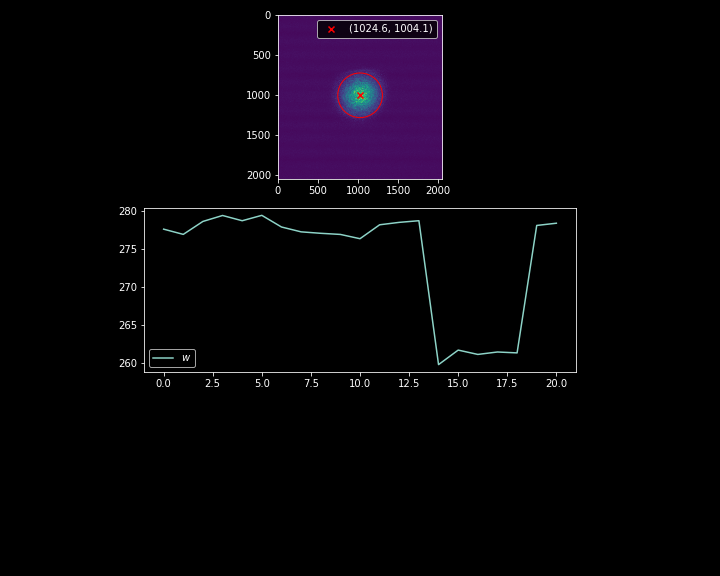

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


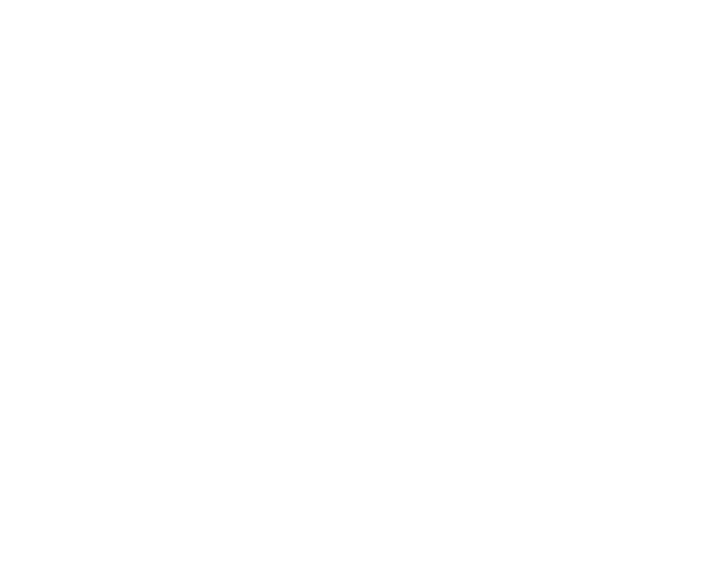

In [137]:
%matplotlib notebook
#fig, ax = plt.subplots(2, figsize=(12,12))
fig = plt.figure(figsize=(10,8))
fig.show()
fig.canvas.draw()
plt.style.use('dark_background')
sx, sy = [], []

frame0 = cam0.get_frame(100)
mx = guess_centroid(frame0)
bounds = bound_roi(frame0, mx, size = 400)
imroi = select_roi(frame0, bounds)
mxroi = guess_centroid(imroi)
fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=False)
sigma_x = fitc[2]
sigma_y = fitr[2]
p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]

while True:
    
    fig = plt.gcf()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)

    frame0 = cam0.get_frame(100)
    
    mx = guess_centroid(frame0)
    bounds = bound_roi(frame0, mx, size = 400)
    imroi = select_roi(frame0, bounds)
    try:
        fit = fitGauss2d(imroi, p0 = p0)
        pars = make_params(fit);
        if (pars[3] > 0 ) and (pars[3] < 300):
            sx.append(pars[3])
        ax2.plot(sx, label='$w$')
        #ax2.set_ylim(15, 25)
        ax2.legend()
    
    except RuntimeError:
        pass
    
    pars = zoom_out(pars, bounds)
    plot_fit_result(frame0, pars, ax=ax1);
    fig.canvas.draw()
    fig.tight_layout()
    #fig.canvas.update()
    fig.canvas.flush_events()
    fig.subplots_adjust(left=0.2, bottom=None, right=0.8, top=None, wspace=0.1, hspace=None)
    plt.clf()     # Clean figure to update legend, barplot...    

In [54]:
frame0 = cam0.get_frame(100)
mx = guess_centroid(frame0)

ax1.add_artist(circleRef)

bounds = bound_roi(frame0, mx, size = 400)
imroi = select_roi(frame0, bounds)
mxroi = guess_centroid(imroi)


fitr, fitc = fitGausRowCol(imroi, mxroi, flag_p=False)
sigma_x = fitc[2]
sigma_y = fitr[2]
p0 = [imroi.max(), mxroi[1], mxroi[0], sigma_x, sigma_y]
fit = fitGauss2d(imroi, p0 = p0)
pars = make_params(fit);
p0 = zoom_out(pars, bounds)

In [55]:
p0[3], rRef

(280.11309598101514, 280.7183325525021)

##### The distance 2f is now 80 cm as it should be
Waist size conserved up to 1 px

# Find distance z to galvo: move mirrors and check image stays put 

In [39]:
p1 = [-1800, 0] # p1
p2 = [-3100, 0] # p2
p3 = [-4800, 0] # p3
p0 = [0,0]
p4 = [+1500, 0] # p4
p5 = [+3000, 0] # p5
p6 = [+900, 0] # p6
p7 = [-800, 0] # p7

r1 = [0, 600] # r1
r2 = [0, 1500] # r2
r3 = [0, -800] # r1
r4 = [0, -1500] # r1

hpoints = [p4, p6, p0, p7, p1, p2]
vpoints = [r2, r1, p0, r3, r4]

for hp in vpoints:
    move_to_positionXY(serialport, position=hp, center=center0, wait=3)

In [40]:
move_to_positionXY(serialport, position=hpoints[2], center=center0, wait=3)

In [71]:
fitsV, fitsH = [], []

## Move every component 12.5 mm further, z = 412.5 mm 

##### So L1 and CAM at 24, L2 at 0 mm

[1162.8265377073199, 1011.7770844639839]
[1159.481858467644, 1011.3378313823274]
[1049.6708831850906, 1008.8104159435048]
[989.5122924461548, 1009.6556191961632]
[915.0468300536102, 1003.0568972213422]
[809.2885909943149, 1002.2121171664041]


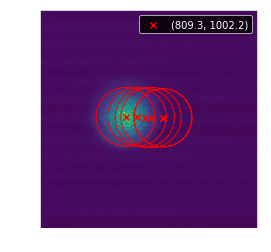

In [85]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[1056.2091069037615, 896.0752230447274]
[1046.4145750524733, 969.6562328074568]
[1049.8542338100342, 1009.0121221594425]
[1047.1767205495808, 1065.8215543053398]
[1048.2359977956316, 1117.1257406327081]


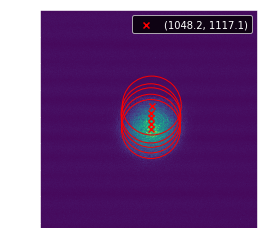

In [86]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)

    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## Displacer center, z = 400 mm

##### Every component displacer scale on 12.5 mm (scale center)

[1093.0070734083467, 1012.663840611176]
[1067.5145445318778, 1005.1898611623022]
[1014.5804507736268, 1010.0771679020902]
[970.6956802328261, 1011.113810443687]
[917.8103212271038, 1006.4305676033084]
[839.219772603717, 1006.3332691265163]


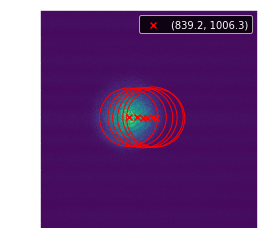

In [87]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[1020.3884764503454, 947.1547427298283]
[1011.3781709305541, 992.3979850552]
[1017.3574940940523, 1008.4002690104724]
[1012.5557834061561, 1039.8131994903688]
[1013.8246350537809, 1067.6245370710408]


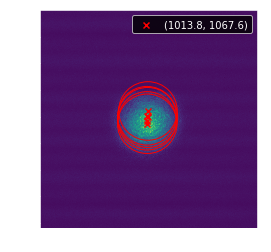

In [88]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 395 mm

##### CAM and L1 scale on 7.5 mm, L2 at 17.5

[1062.7658243789858, 1012.884912797173]
[1046.070745504655, 1004.8306216681585]
[1007.6003223400718, 1010.5749829061908]
[966.8371428378956, 1009.2391662966966]
[918.5526327478877, 1007.7533518845619]
[853.945509769363, 1006.2297936289003]


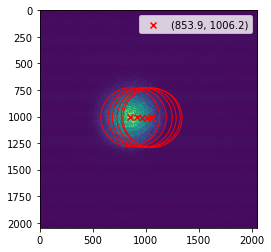

In [105]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[1005.8057904417456, 973.7095993748173]
[997.0447027476034, 1002.817140657279]
[1001.1536139087808, 1010.8977058460443]
[999.2814168904204, 1028.8080538778277]
[999.9991170880057, 1045.3687986510602]


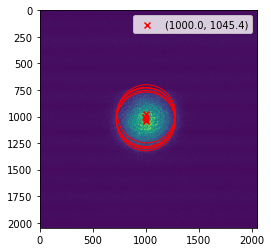

In [106]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 393 mm

##### CAM and L1 scale on 5.5 mm, L2 at 19.5

[1050.9582311822264, 1013.1052224012172]
[1037.1283744776356, 1004.8381598432654]
[996.815497447658, 1008.8215676683251]
[964.555942747256, 1009.8494596742001]
[919.7143525203368, 1008.4373404487305]
[860.7128931896899, 1006.9630894535171]


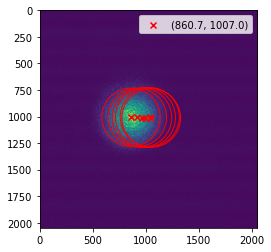

In [109]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[999.5185878877676, 983.9976591787376]
[990.503239109935, 1007.078992600752]
[996.6216322607377, 1008.8309564249521]
[991.4121590819337, 1022.5072377030837]
[992.783373945365, 1034.42437845168]


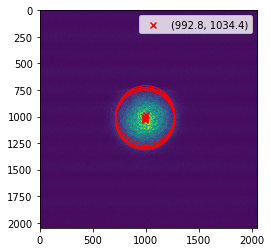

In [110]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 391 mm

##### CAM and L1 scale on 3.5 mm, L2 at 21.5

[1038.674703003649, 1013.5632298671333]
[1027.4087844217051, 1004.5826630594861]
[990.7015852870977, 1009.320728093847]
[961.5890615961321, 1009.6548707876268]
[921.3042320757751, 1008.9435323822655]
[866.6781409480626, 1007.4196124210355]


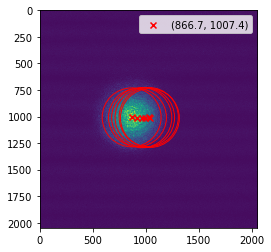

In [112]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[993.6005694668776, 993.8713762401065]
[984.3633662221181, 1011.2438839694997]
[990.8815834967753, 1008.6434736629458]
[985.5563116354871, 1017.7446740153026]
[986.582020500628, 1024.926468907931]


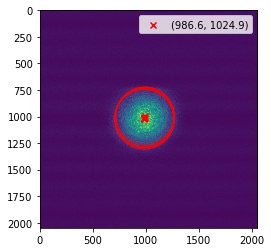

In [113]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 387.5

##### So L1 and CAM at 0, L2 at 24 mm

[1017.4315324308981, 1014.6749419422315]
[1007.646043453313, 1007.9223794368353]
[978.851124422551, 1012.6950064704954]
[957.1562420916778, 1013.8796712003108]
[927.8826947101727, 1008.093472217367]
[885.5794650291142, 1007.9745889469008]


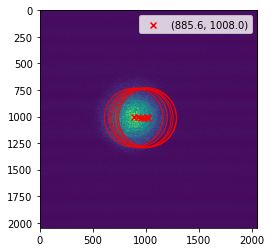

In [115]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[984.2484912075518, 1016.248061355582]
[973.9128806456777, 1020.6663252556023]
[980.4677215950037, 1009.5685338917868]
[975.0964764149998, 1006.4231725977116]
[976.2241097789473, 1003.7049116501233]


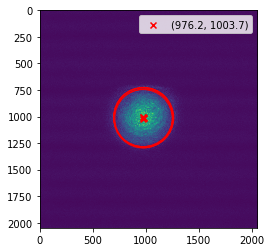

In [116]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 387.5 but in the next screwhole

##### So L1 and CAM at 24, L2 at 0 mm

[1073.632028414776, 1007.7167183711338]
[1045.1410445833862, 1008.8741696077975]
[1018.607152423941, 1011.6983621394882]
[994.5318474860253, 1005.64919962412]
[961.8206319517241, 1010.7861222110228]
[919.1565238572463, 1013.6756856648226]


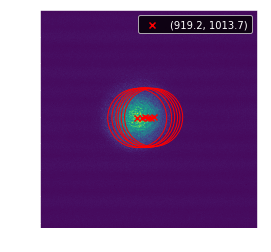

In [138]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[1019.8779004108434, 1015.1717160010542]
[1024.8540390634346, 1008.2486882125481]
[1018.3536150223825, 1012.1327973586212]
[1022.8789633078867, 1003.1509864377931]
[1024.7293255373359, 1004.1551355914393]


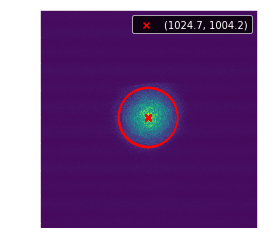

In [139]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 385.0 but in the next screwhole

##### So L1 and CAM at 21.5, L2 at 2.5 mm

[1054.9965885224524, 1006.3345351504698]
[1032.9442075560296, 1008.4812634735054]
[1013.4823756192465, 1012.2375985284002]
[997.2119577611325, 1005.8349030366974]
[972.2360758303616, 1010.6467403004342]
[938.421709502123, 1013.558077468003]


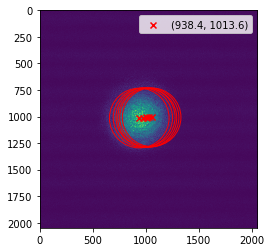

In [141]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[1013.4908594332692, 1033.9356567808225]
[1017.421429659226, 1014.0058775870586]
[1013.6280283425626, 1011.2883023526514]
[1018.3142703962433, 992.2896242088781]
[1018.4810664822317, 982.8135075628564]


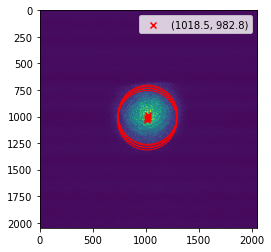

In [142]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 382.5 but in the next screwhole

##### So L1 and CAM at 19.5, L2 at 5 mm

[1361.2931767619311, 1015.1904467969321]
[1346.321312920575, 1015.9944235718364]
[1332.1318143212907, 1016.2296071107368]
[1317.7404297586297, 1015.9703473621121]
[1303.1508768127524, 1016.0004712708729]


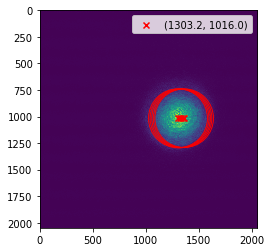

In [178]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[1330.8549989597122, 1046.8443949199163]
[1331.6119132895485, 1032.695795734324]
[1331.9743640720742, 1016.5219805231575]
[1332.1333827015542, 1000.0124315369469]
[1333.296431384474, 985.8830131549194]


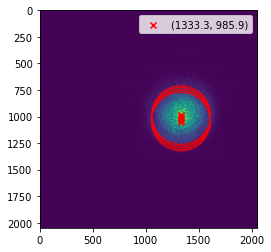

In [179]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 380 mm

##### So L1 and CAM at 17, L2 at 7.5 mm

[1357.1782697329797, 1016.3296808640425]
[1342.7956767185133, 1016.1978024350263]
[1330.0756748579183, 1016.2496999022537]
[1317.1535661109724, 1016.0809755453245]
[1303.9798314625077, 1015.8604349248156]


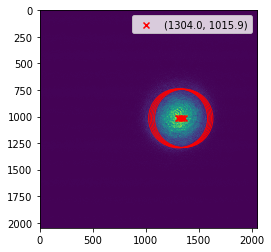

In [181]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[1329.1264153690963, 1051.0879398999273]
[1329.7220423749327, 1034.51757305913]
[1330.3458130838878, 1015.6202969970428]
[1330.463382156824, 997.3136634431886]
[1331.606296026048, 980.943654600058]


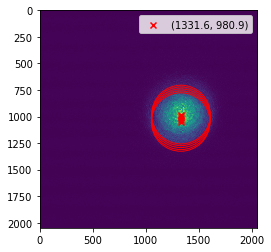

In [182]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 377.5 mm

##### So L1 and CAM at 14.5, L2 at 10 mm

[1341.3530397017716, 1016.5404726699377]
[1332.5702433690262, 1016.3983559250388]
[1325.9979832633471, 1016.5227669411145]
[1319.2251850240762, 1016.4894544254121]
[1312.2948253097413, 1016.3541236236372]


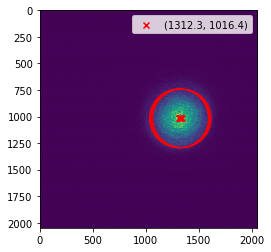

In [184]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[1325.3463240950437, 1071.0314709765555]
[1325.8844280717944, 1044.7732763301237]
[1326.1613549856188, 1016.3661364235453]
[1326.2553118739793, 987.934050265611]
[1327.198982695812, 961.2531747167914]


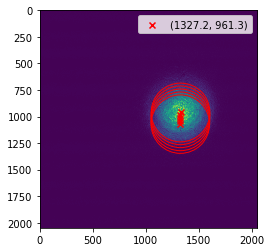

In [185]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## z = 375 mm

##### So L1 and CAM at 12, L2 at 12.5 mm

[1330.5389233265823, 1016.7439558566737]
[1325.9484906762418, 1017.5011951635294]
[1323.056458800415, 1017.2676458456433]
[1320.058135100747, 1017.0233363088327]
[1316.8394690911846, 1016.8092077755507]


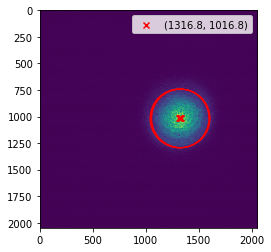

In [188]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsH.append(fitsh)

[1322.5181693364186, 1083.5022062097019]
[1322.853376035317, 1051.5251373283663]
[1323.1479844724522, 1016.7404397302372]
[1323.2549270069492, 982.1696801978268]
[1324.2350780051743, 949.7839418230868]


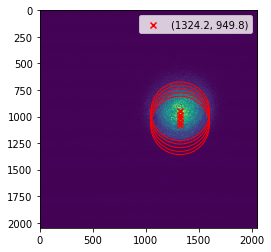

In [189]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
    sleep(3)
fitsV.append(fitsv)

## Plot results 

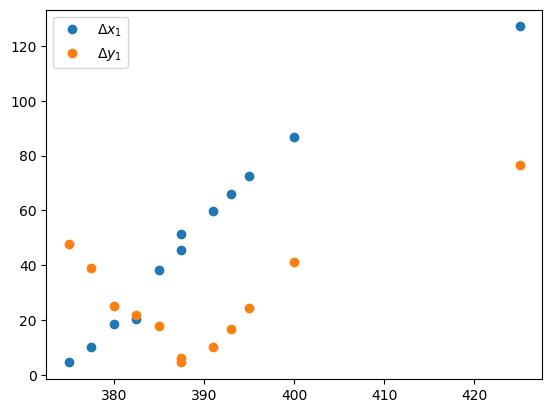

In [192]:
z = [425, 400, 395, 393, 391, 387.5, 387.5, 385, 382.5, 380, 377.5, 375]

sizesV = [np.matrix(f)[1, 3] - np.matrix(f)[2,3] for f in fitsV]
sizesH = [np.matrix(f)[1, 3] - np.matrix(f)[2,3] for f in fitsH]

dy1  = [np.std(np.matrix(f)[:,2]) for f in fitsV]
dx1  = [np.std(np.matrix(f)[:,1]) for f in fitsH]

plt.style.use('default')
#plt.plot(z, sizesH, 'X', label='$w_H$')
#plt.plot(z, sizesV, 'X', label='$w_V$')

plt.plot(z, dx1, 'o', label='$\Delta x_1$')
plt.plot(z, dy1, 'o', label='$\Delta y_1$')

plt.legend()

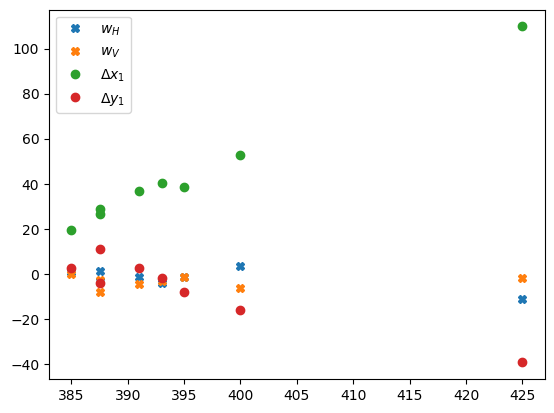

In [146]:
sizesV = [np.matrix(f)[1, 3] - np.matrix(f)[2,3] for f in fitsV]
sizesH = [np.matrix(f)[1, 3] - np.matrix(f)[2,3] for f in fitsH]

dy1 = [np.matrix(f)[1, 2] - np.matrix(f)[2,2] for f in fitsV]
dx1 = [np.matrix(f)[1, 1] - np.matrix(f)[2,1] for f in fitsH]

dy2 = [np.matrix(f)[3, 2] - np.matrix(f)[2,2] for f in fitsV]
dx2 = [np.matrix(f)[3, 1] - np.matrix(f)[2,1] for f in fitsH]


plt.style.use('default')
plt.plot(z, sizesH, 'X', label='$w_H$')
plt.plot(z, sizesV, 'X', label='$w_V$')

plt.plot(z, dx1, 'o', label='$\Delta x_1$')
plt.plot(z, dy1, 'o', label='$\Delta y_1$')

#plt.plot(z, dx2, 'o', label='$\Delta x_2$')
#plt.plot(z, dy2, 'o', label='$\Delta y_2$')
plt.legend()

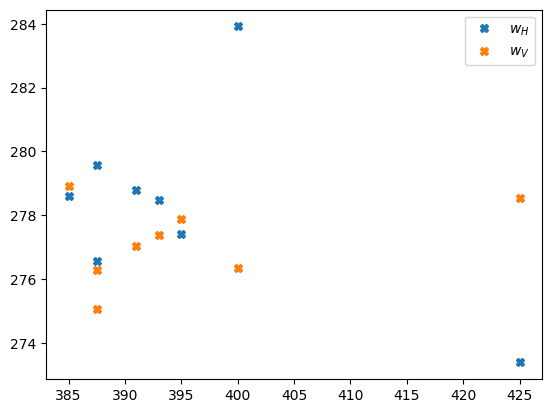

In [149]:
sizesV = [np.matrix(f)[1, 3] for f in fitsV]
sizesH = [np.matrix(f)[1, 3] for f in fitsH]


plt.style.use('default')
plt.plot(z, sizesH, 'X', label='$w_H$')
plt.plot(z, sizesV, 'X', label='$w_V$')


plt.legend()

In [125]:
rRef

280.7183325525021

In [148]:
fitsv[-1][3]

278.62181566838734

# Now back on L1, CAM 0 25, move L2

## L2 = 1mm

In [150]:
fitsV2, fitsH2 = [], []

[1068.9003283054808, 1006.4232340249056]
[1044.5059441727533, 1009.2836506884258]
[1018.9125794280432, 1012.4426284693939]
[996.053574854495, 1006.1349091657858]
[965.1817019918894, 1011.402050316858]
[922.4314597592578, 1013.4464257290547]


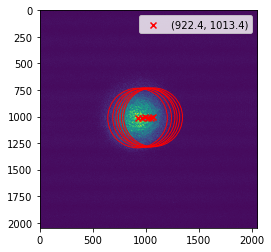

In [151]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
fitsH2.append(fitsh)

[1018.9959483604059, 1017.5008806867983]
[1021.6711723028795, 1008.1517932862411]
[1018.9553017859872, 1012.001080211765]
[1023.1517240777418, 1002.534458290191]
[1024.0383903808624, 1000.2081907292087]


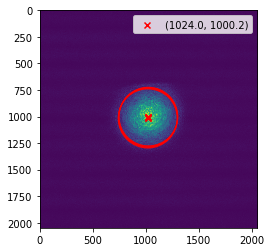

In [152]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
fitsV2.append(fitsv)

## L2 = 3mm

[1075.2538360557323, 1005.2193983745711]
[1047.9528285272602, 1008.210660937953]
[1018.4830162775608, 1011.2596359521658]
[992.3106292970954, 1004.5807359233677]
[957.2388829254136, 1009.6793116255956]
[908.9765841315761, 1012.2779961163344]


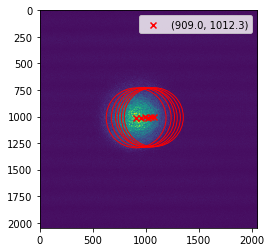

In [153]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
fitsH2.append(fitsh)

[1017.6613186266834, 1007.1795659168063]
[1022.2342650022871, 1003.7604294862163]
[1020.7880137641159, 1012.2809067241236]
[1025.7115918916497, 1006.9847595097932]
[1024.1406995659624, 1007.7407262566692]


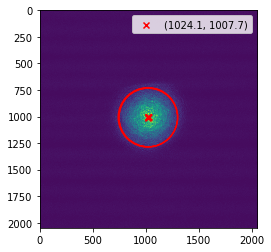

In [154]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
fitsV2.append(fitsv)

## L2 = 5mm

[1083.8883600002473, 1005.9261071725591]
[1055.7463573915102, 1008.8908208197612]
[1019.695129936296, 1010.6112937070415]
[990.7251418955906, 1003.855450884906]
[951.1551037526663, 1008.8513611449957]
[897.8229421067404, 1011.5669874871705]


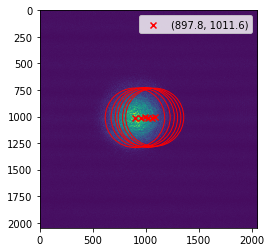

In [156]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
fitsH2.append(fitsh)

[1010.1207066612137, 1006.1559314008265]
[1023.5827003209911, 998.4300389617691]
[1019.4264958075329, 1010.5271452655111]
[1025.1352532140068, 1009.2222539787551]
[1026.300362310899, 1017.9926213695894]


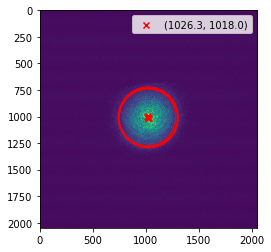

In [157]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
fitsV2.append(fitsv)

## L2 = 3mm, L1 = 27 mm

[1082.492752985267, 1004.5156948662793]
[1052.615314110934, 1007.8226913300562]
[1020.148379259046, 1011.1923094043591]
[993.150572572333, 1005.6983157506011]
[955.2232309084632, 1010.8716058882055]
[902.2228915076897, 1013.1622652761966]


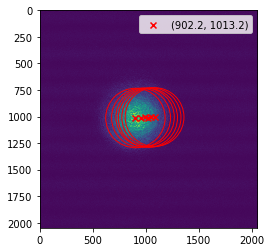

In [159]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
fitsH2.append(fitsh)

[1021.7677574794368, 999.4690778038685]
[1026.2894730313953, 1001.235227980773]
[1020.1897543575103, 1011.5053131618104]
[1025.251543568504, 1009.6741902897098]
[1025.5768759108728, 1015.9799006221155]


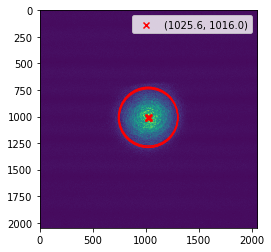

In [160]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
fitsV2.append(fitsv)

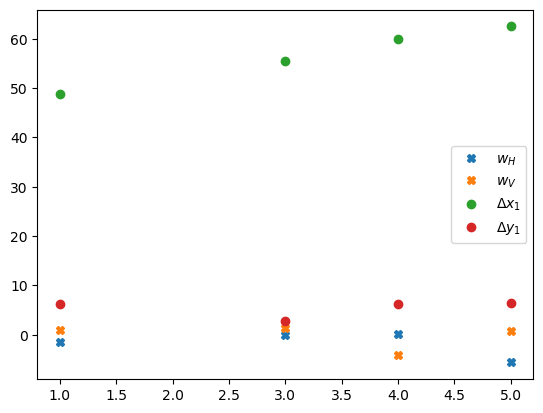

In [162]:
z = [1, 3, 5, 4]

sizesV = [np.matrix(f)[1, 3] - np.matrix(f)[2,3] for f in fitsV2]
sizesH = [np.matrix(f)[1, 3] - np.matrix(f)[2,3] for f in fitsH2]

dy1  = [np.std(np.matrix(f)[:,2]) for f in fitsV2]
dx1  = [np.std(np.matrix(f)[:,1]) for f in fitsH2]

plt.style.use('default')
plt.plot(z, sizesH, 'X', label='$w_H$')
plt.plot(z, sizesV, 'X', label='$w_V$')

plt.plot(z, dx1, 'o', label='$\Delta x_1$')
plt.plot(z, dy1, 'o', label='$\Delta y_1$')

plt.legend()

## Try with same galvo shifts in x and y (not fair to compare otherwise) 

In [164]:
p1 = [-1500, 0] # p1
p0 = [0,0]
p4 = [+1500, 0] # p4
p6 = [+750, 0] # p6
p7 = [-750, 0] # p7

r1 = [0, 750] # r1
r2 = [0, 1500] # r2
r3 = [0, -750] # r1
r4 = [0, -1500] # r1

hpoints = [p4, p6, p0, p7, p1]
vpoints = [r2, r1, p0, r3, r4]

In [172]:
import cv2

ModuleNotFoundError: No module named 'cv2'

[1389.4853672060744, 1014.9277201587491]
[1363.5932020762207, 1014.8796293509059]
[1338.985010161009, 1014.8124204379701]
[1314.2643496181222, 1014.6865582573895]
[1288.974272841901, 1014.6441549143769]


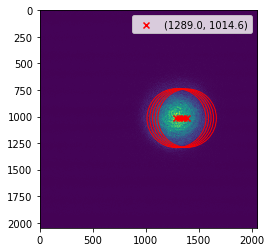

In [173]:
%matplotlib inline
fitsh = []
for hp in hpoints:
    move_to_positionXY(serialport, position=hp, center=center0)
    sleep(1)
    
    frameh = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(frameh, flag_p=False)
    fitsh.append(bestfit1)
    
    plot_fit_result(frameh, bestfit1)
    print(bestfit1[1:3])
fitsH2.append(fitsh)

[1337.3291386486408, 1011.9202353540272]
[1338.5020325740604, 1014.6374858857727]
[1338.8007786451872, 1014.9647578966983]
[1339.0916557768285, 1015.3166319799903]
[1340.1030252950313, 1018.3405825117541]


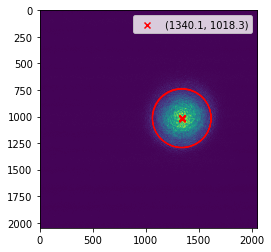

In [174]:
%matplotlib inline
fitsv = []
for vp in vpoints:
    move_to_positionXY(serialport, position=vp, center=center0)
    sleep(1)
    
    framev = cam0.get_frame(100)
    
    bestfit1 = guessNfitGaussian2d(framev, flag_p=False)
    fitsv.append(bestfit1)
    
    plot_fit_result(framev, bestfit1)
    print(bestfit1[1:3])
fitsV2.append(fitsv)

In [177]:
np.arctan(3/370) 

0.008107930435610665

In [171]:
move_to_positionXY(serialport, position=hpoints[2], center=center0)